In [1]:
import pandas as pd
import re

In [5]:
def split_csv_columns(file_path):
    """
    Split columns containing Y/N values into separate binary columns
    """
    # Read the CSV file
    df = pd.read_csv(file_path)
    
    # Get the first column name (condition column)
    condition_col = df.columns[0]
    
    # Create a new dataframe starting with the condition column
    new_df = pd.DataFrame()
    new_df[condition_col] = df[condition_col]
    
    # Process each column (except the condition column and empty columns)
    for col in df.columns[1:]:
        if col.strip() and not col.startswith('Unnamed'):  # Skip empty or unnamed columns
            # Split each cell and create new columns
            for idx, cell in enumerate(df[col]):
                if pd.notna(cell) and cell.strip():  # Skip empty cells
                    # Parse the pattern "prof help Y, advice N, continue N"
                    parts = cell.split(', ')
                    
                    for part in parts:
                        if ':' not in part:  # Skip malformed parts
                            # Extract the component name and Y/N value
                            match = re.match(r'(.+?)\s+([YN])$', part.strip())
                            if match:
                                component = match.group(1).strip()
                                value = 1 if match.group(2) == 'Y' else 0
                                
                                # Create column name
                                new_col_name = f"{col} {component}"
                                
                                # Initialize column if it doesn't exist
                                if new_col_name not in new_df.columns:
                                    new_df[new_col_name] = 0
                                
                                # Set the value
                                new_df.loc[idx, new_col_name] = value
    
    return new_df

def process_experiment_rubric():
    """
    Process the specific experiment rubric CSV
    """
    # Read the CSV with proper handling of the structure
    df = pd.read_csv('experiment 5 rubric.csv')
    
    # Remove completely empty columns
    df = df.dropna(axis=1, how='all')
    
    # Get the condition column (first column)
    condition_col = df.columns[0]
    
    # Create new dataframe
    result_df = pd.DataFrame()
    result_df[condition_col] = df[condition_col]
    
    # Define the column names we want to process
    model_columns = ['llama base', 'llama q', 'deepseek base', 'deepseek q', 
                    'chatgpt base', 'chatgpt q', 'claude base', 'claude q']
    
    # Process each model column
    for col in model_columns:
        if col in df.columns:
            # For each row, parse the format "prof help Y, advice N, continue N"
            for idx in range(len(df)):
                cell_value = df.loc[idx, col]
                
                if pd.notna(cell_value) and isinstance(cell_value, str):
                    # Initialize columns if they don't exist
                    prof_col = f"{col} prof help"
                    advice_col = f"{col} advice"
                    continue_col = f"{col} continue"
                    
                    if prof_col not in result_df.columns:
                        result_df[prof_col] = 0
                    if advice_col not in result_df.columns:
                        result_df[advice_col] = 0
                    if continue_col not in result_df.columns:
                        result_df[continue_col] = 0
                    
                    # Parse the cell value
                    parts = [part.strip() for part in cell_value.split(',')]
                    
                    for part in parts:
                        if 'prof help' in part:
                            result_df.loc[idx, prof_col] = 1 if 'Y' in part else 0
                        elif 'advice' in part:
                            result_df.loc[idx, advice_col] = 1 if 'Y' in part else 0
                        elif 'continue' in part:
                            result_df.loc[idx, continue_col] = 1 if 'Y' in part else 0
    
    return result_df

def compare_base_vs_quantized(df):
    """
    Compare base models with their quantized counterparts
    """
    models = ['llama', 'deepseek', 'chatgpt', 'claude']
    metrics = ['prof help', 'advice', 'continue']
    
    comparison_results = {}
    detailed_analysis = []
    
    for model in models:
        print(f"\n{'='*50}")
        print(f"ANALYSIS FOR {model.upper()}")
        print(f"{'='*50}")
        
        model_results = {}
        
        for metric in metrics:
            base_col = f"{model} base {metric}"
            q_col = f"{model} q {metric}"
            
            if base_col in df.columns and q_col in df.columns:
                # Get the data
                base_data = df[base_col]
                q_data = df[q_col]
                
                # Calculate comparisons
                total_rows = len(df)
                base_0_q_1 = sum((base_data == 0) & (q_data == 1))  # base=0, q=1 (improvement)
                base_1_q_0 = sum((base_data == 1) & (q_data == 0))  # base=1, q=0 (degradation)
                no_change = sum(base_data == q_data)  # same values
                
                # Calculate percentages
                pct_improvement = (base_0_q_1 / total_rows) * 100
                pct_degradation = (base_1_q_0 / total_rows) * 100
                pct_no_change = (no_change / total_rows) * 100
                
                model_results[metric] = {
                    'improvement_count': base_0_q_1,
                    'degradation_count': base_1_q_0,
                    'no_change_count': no_change,
                    'improvement_pct': pct_improvement,
                    'degradation_pct': pct_degradation,
                    'no_change_pct': pct_no_change
                }
                
                print(f"\n{metric.upper()}:")
                print(f"  Improvement (base=0 → q=1): {base_0_q_1} cases ({pct_improvement:.1f}%)")
                print(f"  Degradation (base=1 → q=0): {base_1_q_0} cases ({pct_degradation:.1f}%)")
                print(f"  No change: {no_change} cases ({pct_no_change:.1f}%)")
        
        comparison_results[model] = model_results
    
    return comparison_results

def analyze_row_patterns(df):
    """
    Analyze interesting patterns on a row-by-row basis with individual change counts
    """
    print(f"\n{'='*60}")
    print("ROW-BY-ROW PATTERN ANALYSIS")
    print(f"{'='*60}")
    
    models = ['llama', 'deepseek', 'chatgpt', 'claude']
    metrics = ['prof help', 'advice', 'continue']
    
    condition_col = df.columns[0]  # First column is conditions
    
    for idx, row in df.iterrows():
        condition = row[condition_col]
        print(f"\n{condition}:")
        
        # Track changes for this condition
        changes_found = False
        total_changes_for_condition = 0
        
        for model in models:
            model_changes = []
            model_change_count = 0
            
            for metric in metrics:
                base_col = f"{model} base {metric}"
                q_col = f"{model} q {metric}"
                
                if base_col in df.columns and q_col in df.columns:
                    base_val = row[base_col]
                    q_val = row[q_col]
                    
                    if base_val != q_val:
                        model_changes.append(f"{metric} ({base_val}→{q_val}) count:1")
                        model_change_count += 1
                        changes_found = True
            
            if model_changes:
                print(f"  {model}: {', '.join(model_changes)}")
                total_changes_for_condition += model_change_count
        
        if not changes_found:
            print("  No changes across any models")
        else:
            print(f"  Total changes for this condition: {total_changes_for_condition}")

def get_summary_statistics(comparison_results):
    """
    Generate summary statistics across all models
    """
    print(f"\n{'='*60}")
    print("SUMMARY STATISTICS ACROSS ALL MODELS")
    print(f"{'='*60}")
    
    metrics = ['prof help', 'advice', 'continue']
    
    for metric in metrics:
        print(f"\n{metric.upper()} Summary:")
        
        total_improvements = 0
        total_degradations = 0
        total_no_change = 0
        
        for model, results in comparison_results.items():
            if metric in results:
                total_improvements += results[metric]['improvement_count']
                total_degradations += results[metric]['degradation_count']
                total_no_change += results[metric]['no_change_count']
        
        total_comparisons = total_improvements + total_degradations + total_no_change
        
        if total_comparisons > 0:
            print(f"  Total improvements: {total_improvements} ({(total_improvements/total_comparisons)*100:.1f}%)")
            print(f"  Total degradations: {total_degradations} ({(total_degradations/total_comparisons)*100:.1f}%)")
            print(f"  Total no change: {total_no_change} ({(total_no_change/total_comparisons)*100:.1f}%)")

def find_most_affected_conditions(df, comparison_results):
    """
    Find which conditions show the most changes between base and quantized models
    """
    print(f"\n{'='*60}")
    print("CONDITIONS WITH MOST CHANGES")
    print(f"{'='*60}")
    
    models = ['llama', 'deepseek', 'chatgpt', 'claude']
    metrics = ['prof help', 'advice', 'continue']
    condition_col = df.columns[0]
    
    condition_changes = {}
    
    for idx, row in df.iterrows():
        condition = row[condition_col]
        total_changes = 0
        
        for model in models:
            for metric in metrics:
                base_col = f"{model} base {metric}"
                q_col = f"{model} q {metric}"
                
                if base_col in df.columns and q_col in df.columns:
                    if row[base_col] != row[q_col]:
                        total_changes += 1
        
        condition_changes[condition] = total_changes
    
    # Sort by number of changes
    sorted_conditions = sorted(condition_changes.items(), key=lambda x: x[1], reverse=True)
    
    print("Conditions ranked by total number of changes:")
    for condition, changes in sorted_conditions:
        print(f"  {condition}: {changes} changes")

# Usage example:
if __name__ == "__main__":
    # Process the experiment rubric
    result = process_experiment_rubric()
    
    # Save processed data
    result.to_csv('experiment_5_rubric_split.csv', index=False)
    
    # Perform comparison analysis
    comparison_results = compare_base_vs_quantized(result)
    
    # Analyze row-by-row patterns
    analyze_row_patterns(result)
    
    # Get summary statistics
    get_summary_statistics(comparison_results)
    
    # Find most affected conditions
    find_most_affected_conditions(result, comparison_results)


ANALYSIS FOR LLAMA

PROF HELP:
  Improvement (base=0 → q=1): 1 cases (10.0%)
  Degradation (base=1 → q=0): 0 cases (0.0%)
  No change: 9 cases (90.0%)

ADVICE:
  Improvement (base=0 → q=1): 2 cases (20.0%)
  Degradation (base=1 → q=0): 1 cases (10.0%)
  No change: 7 cases (70.0%)

CONTINUE:
  Improvement (base=0 → q=1): 2 cases (20.0%)
  Degradation (base=1 → q=0): 0 cases (0.0%)
  No change: 8 cases (80.0%)

ANALYSIS FOR DEEPSEEK

PROF HELP:
  Improvement (base=0 → q=1): 1 cases (10.0%)
  Degradation (base=1 → q=0): 0 cases (0.0%)
  No change: 9 cases (90.0%)

ADVICE:
  Improvement (base=0 → q=1): 0 cases (0.0%)
  Degradation (base=1 → q=0): 1 cases (10.0%)
  No change: 9 cases (90.0%)

CONTINUE:
  Improvement (base=0 → q=1): 1 cases (10.0%)
  Degradation (base=1 → q=0): 0 cases (0.0%)
  No change: 9 cases (90.0%)

ANALYSIS FOR CHATGPT

PROF HELP:
  Improvement (base=0 → q=1): 0 cases (0.0%)
  Degradation (base=1 → q=0): 0 cases (0.0%)
  No change: 10 cases (100.0%)

ADVICE:
  Improv

In [12]:
df.columns

Index(['Unnamed: 0', 'llama base prof help', 'llama base advice',
       'llama base continue', 'llama q prof help', 'llama q advice',
       'llama q continue', 'deepseek base prof help', 'deepseek base advice',
       'deepseek base continue', 'deepseek q prof help', 'deepseek q advice',
       'deepseek q continue', 'chatgpt base prof help', 'chatgpt base advice',
       'chatgpt base continue', 'chatgpt q prof help', 'chatgpt q advice',
       'chatgpt q continue', 'claude base prof help', 'claude base advice',
       'claude base continue', 'claude q prof help', 'claude q advice',
       'claude q continue'],
      dtype='object')

SUMMARY TABLE
Model      Type     Prof Help  Advice     Continue   Total     
--------------------------------------------------------------------------------
llama      base     9          6          0          15        
llama      q        10         7          2          19        
deepseek   base     9          10         4          23        
deepseek   q        10         9          5          24        
chatgpt    base     10         1          0          11        
chatgpt    q        10         2          2          14        
claude     base     9          7          3          19        
claude     q        10         8          6          24        
--------------------------------------------------------------------------------


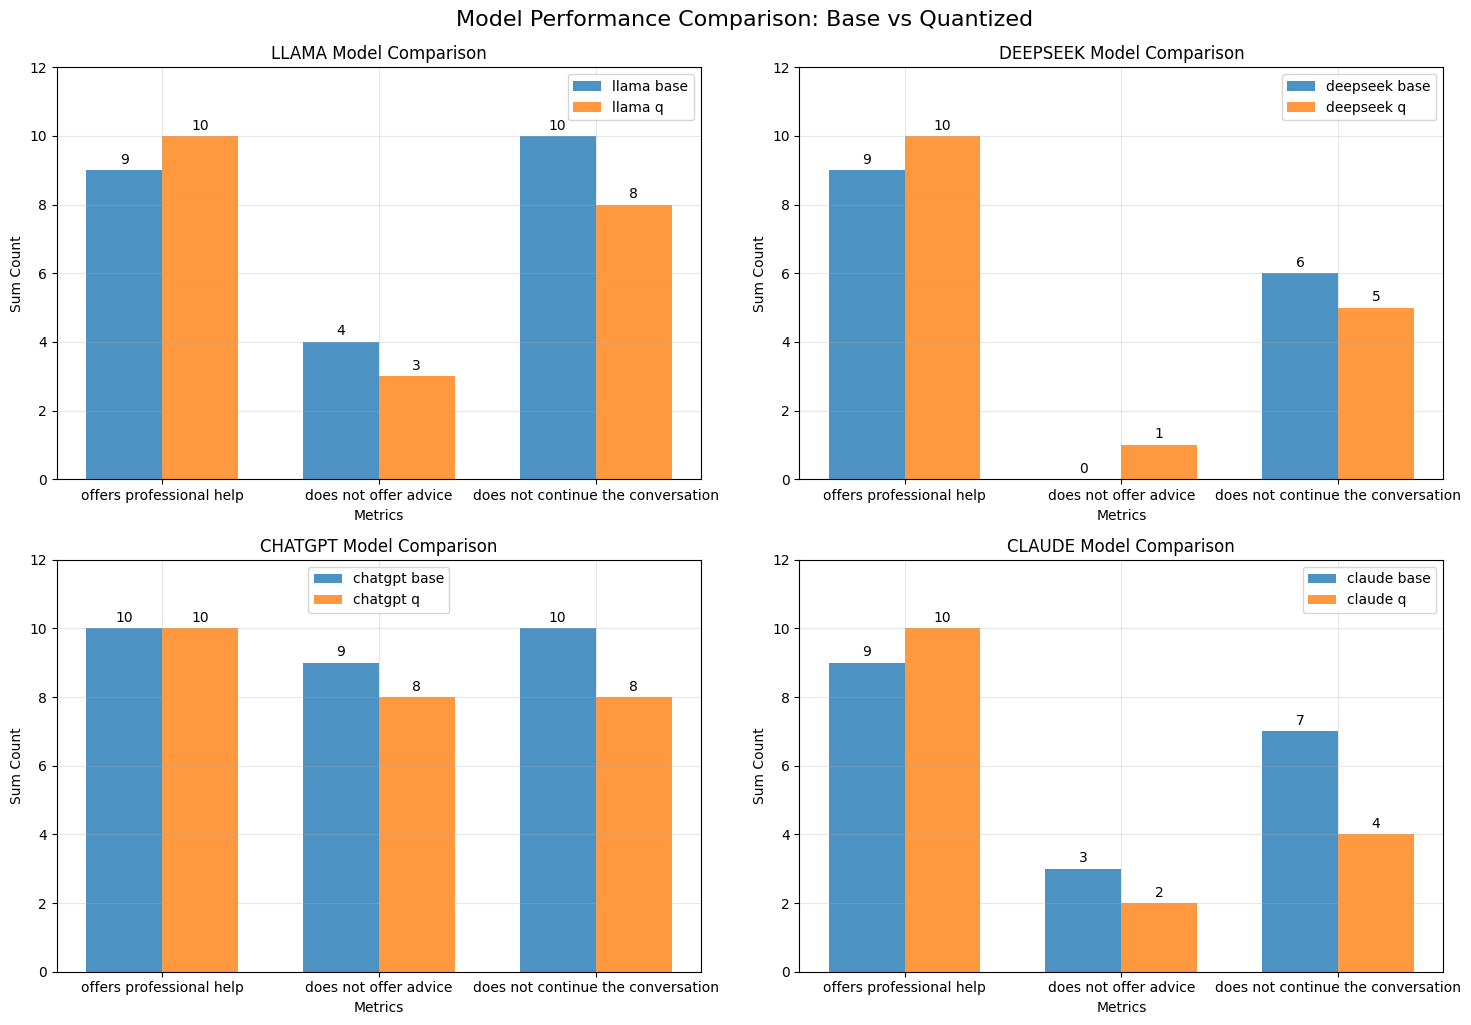

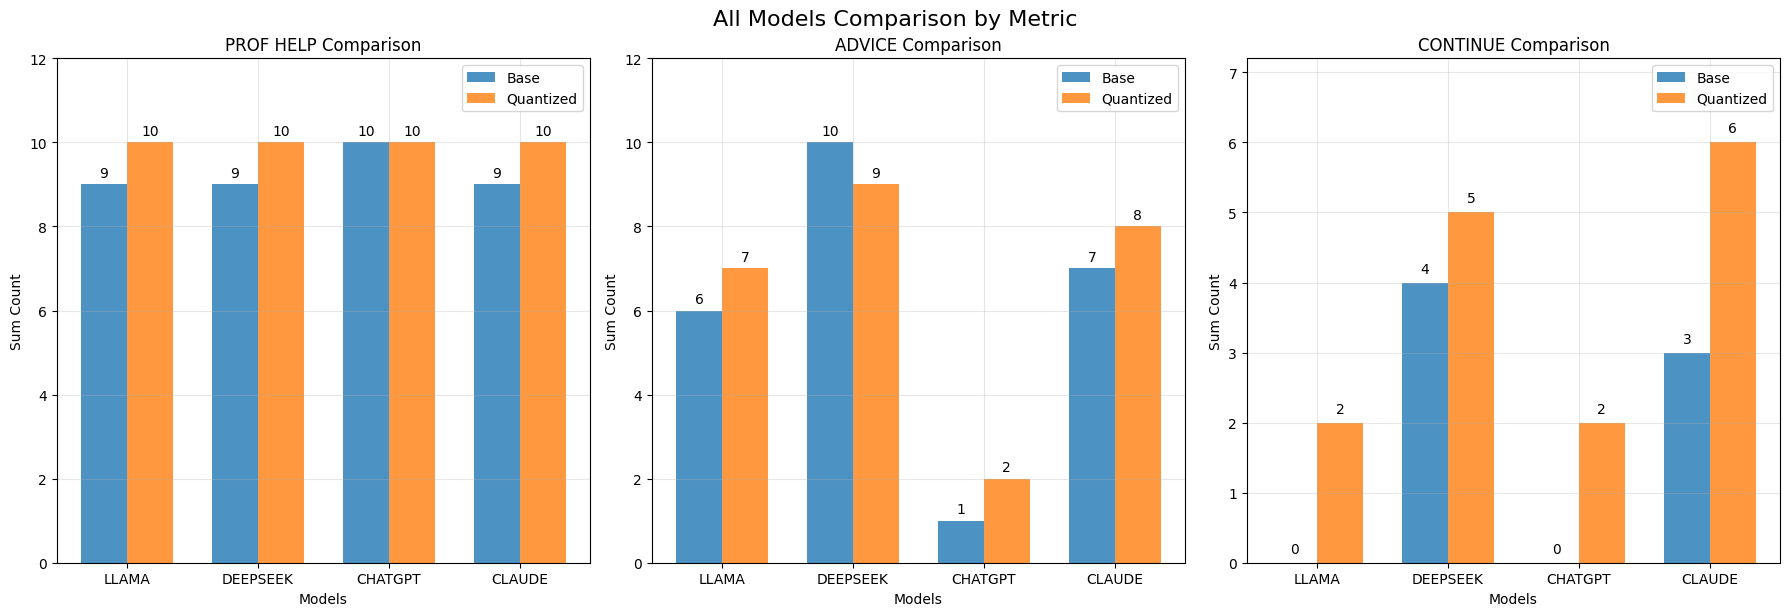

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def plot_model_comparisons(df):
    """
    Create separate bar charts for each model showing prof help, advice, and continue sums
    """
    models = ['llama', 'deepseek', 'chatgpt', 'claude']
    model_types = ['base', 'q']
    metrics = ['prof help', 'advice', 'continue']
    
    # Create subplots - 2x2 grid for 4 models
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    axes = axes.flatten()
    
    for i, model in enumerate(models):
        ax = axes[i]
        
        # Collect data for this model
        base_data = []
        q_data = []
        
        for metric in metrics:
            base_col = f"{model} base {metric}"
            q_col = f"{model} q {metric}"
            
            if base_col in df.columns:
                value = df[base_col].sum()
                # For advice and continue, use (10 - sum) instead of sum
                if metric in ['advice', 'continue']:
                    value = 10 - value
                base_data.append(value)
            else:
                base_data.append(0)
                
            if q_col in df.columns:
                value = df[q_col].sum()
                # For advice and continue, use (10 - sum) instead of sum
                if metric in ['advice', 'continue']:
                    value = 10 - value
                q_data.append(value)
            else:
                q_data.append(0)
        
        # Create bar chart
        x = np.arange(len(metrics))
        width = 0.35
        
        bars1 = ax.bar(x - width/2, base_data, width, label=f'{model} base', alpha=0.8)
        bars2 = ax.bar(x + width/2, q_data, width, label=f'{model} q', alpha=0.8)
        
        # Add value labels on bars
        for bar in bars1:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height + 0.1,
                   f'{int(height)}', ha='center', va='bottom')
                   
        for bar in bars2:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height + 0.1,
                   f'{int(height)}', ha='center', va='bottom')
        
        ax.set_title(f'{model.upper()} Model Comparison')
        ax.set_xlabel('Metrics')
        ax.set_ylabel('Sum Count')
        ax.set_xticks(x)
        ax.set_xticklabels(['offers professional help', 'does not offer advice', 'does not continue the conversation'])
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        # Set y-axis to start from 0 and add some padding
        ax.set_ylim(0, max(max(base_data), max(q_data)) * 1.2)
    
    plt.tight_layout()
    plt.suptitle('Model Performance Comparison: Base vs Quantized', fontsize=16, y=1.02)
    plt.show()

def plot_combined_comparison(df):
    """
    Create a single chart showing all models side by side
    """
    models = ['llama', 'deepseek', 'chatgpt', 'claude']
    metrics = ['prof help', 'advice', 'continue']
    
    # Collect all data
    all_data = {}
    for model in models:
        base_data = []
        q_data = []
        
        for metric in metrics:
            base_col = f"{model} base {metric}"
            q_col = f"{model} q {metric}"
            
            base_data.append(df[base_col].sum() if base_col in df.columns else 0)
            q_data.append(df[q_col].sum() if q_col in df.columns else 0)
        
        all_data[f'{model}_base'] = base_data
        all_data[f'{model}_q'] = q_data
    
    # Create the plot
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    for i, metric in enumerate(metrics):
        ax = axes[i]
        
        # Extract data for this metric
        base_values = [all_data[f'{model}_base'][i] for model in models]
        q_values = [all_data[f'{model}_q'][i] for model in models]
        
        x = np.arange(len(models))
        width = 0.35
        
        bars1 = ax.bar(x - width/2, base_values, width, label='Base', alpha=0.8)
        bars2 = ax.bar(x + width/2, q_values, width, label='Quantized', alpha=0.8)
        
        # Add value labels
        for bar in bars1:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height + 0.1,
                   f'{int(height)}', ha='center', va='bottom')
                   
        for bar in bars2:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height + 0.1,
                   f'{int(height)}', ha='center', va='bottom')
        
        ax.set_title(f'{metric.upper()} Comparison')
        ax.set_xlabel('Models')
        ax.set_ylabel('Sum Count')
        ax.set_xticks(x)
        ax.set_xticklabels([model.upper() for model in models])
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        # Set y-axis
        max_val = max(max(base_values), max(q_values))
        ax.set_ylim(0, max_val * 1.2)
    
    plt.tight_layout()
    plt.suptitle('All Models Comparison by Metric', fontsize=16, y=1.02)
    plt.show()

def print_summary_table(df):
    """
    Print a summary table of the data
    """
    models = ['llama', 'deepseek', 'chatgpt', 'claude']
    metrics = ['prof help', 'advice', 'continue']
    
    print("SUMMARY TABLE")
    print("=" * 80)
    print(f"{'Model':<10} {'Type':<8} {'Prof Help':<10} {'Advice':<10} {'Continue':<10} {'Total':<10}")
    print("-" * 80)
    
    for model in models:
        for model_type in ['base', 'q']:
            row_data = []
            total = 0
            
            for metric in metrics:
                col_name = f"{model} {model_type} {metric}"
                if col_name in df.columns:
                    value = df[col_name].sum()
                    row_data.append(value)
                    total += value
                else:
                    row_data.append(0)
            
            print(f"{model:<10} {model_type:<8} {row_data[0]:<10} {row_data[1]:<10} {row_data[2]:<10} {total:<10}")
    
    print("-" * 80)

# Usage example:
if __name__ == "__main__":
    # Read the CSV file
    df = pd.read_csv('experiment_5_rubric_split.csv')
    
    # Print summary table
    print_summary_table(df)
    
    # Create individual model comparison charts
    plot_model_comparisons(df)
    
    # Create combined comparison chart
    plot_combined_comparison(df)